## Import libraries

In [9]:
from math import sqrt, ceil
import os
from os import listdir
import shutil
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras import applications

## Define constants

In [10]:
COLAB = False

# Do a better code
if not COLAB:
    DATASET_PATH = "../res/dataset/"
    
    MODEL_CP_DIR = "../res/modelcp/"
    WEIGHT_PATH = {"local": MODEL_CP_DIR+"local/", "remote": MODEL_CP_DIR+"remote/"}
    
    CONFIG = {"load": True, "load_remote": True, "load_model": True}
else:
    MODEL_CP_DIR = ""
    WEIGHT_PATH = {"local": MODEL_CP_DIR+"", "remote": MODEL_CP_DIR+""}
    CONFIG = {"load": False, "load_remote": True, "load_model": True}

PATHS = {"train": DATASET_PATH+"train/", "val": DATASET_PATH+"val/", "test": DATASET_PATH+"test/"}
PATH_LABELS = {"normal": "NORMAL/", "bacteria": "BACTERIA/", "virus": "VIRUS/", "pneumonia": "PNEUMONIA/"}

LABELS = [item.lower() for item in os.listdir(PATHS["train"])]

## Load the data

### Utility functions

In [11]:
def separate_pneuomia_classes(dir):
    label_dir = {"pneumonia": dir+PATH_LABELS["pneumonia"], "bacteria": dir+PATH_LABELS["bacteria"], "virus": dir+PATH_LABELS["virus"]}
    
    if os.path.exists(label_dir["bacteria"]) or os.path.exists(label_dir["virus"]):
        return
    else:
        os.mkdir(label_dir["bacteria"])
        os.mkdir(label_dir["virus"])
    
    for f in listdir(label_dir["pneumonia"]):
        shutil.move(label_dir["pneumonia"]+f, label_dir["virus"] if "virus" in f else label_dir["bacteria"])
        
    shutil.rmtree(label_dir["pneumonia"])

In [12]:
separate_pneuomia_classes(PATHS["train"])
separate_pneuomia_classes(PATHS["val"])
separate_pneuomia_classes(PATHS["test"])

BATCH_SIZE = 16

COLOR_MODE = "grayscale"
CLASS_MODE = "categorical"
RESCALE = 1./255
INPUT_SHAPE = (150, 150, 1)

datagen = ImageDataGenerator(rescale=RESCALE)

# Remember: data augmentation only on the train_generator --> Create 2 datagens
train_generator = datagen.flow_from_directory(PATHS["train"], target_size = INPUT_SHAPE[0:2], batch_size=BATCH_SIZE, color_mode=COLOR_MODE, class_mode=CLASS_MODE)
val_generator = datagen.flow_from_directory(PATHS["val"], target_size = INPUT_SHAPE[0:2], batch_size=BATCH_SIZE, color_mode=COLOR_MODE, class_mode=CLASS_MODE)
test_generator = datagen.flow_from_directory(PATHS["test"], target_size = INPUT_SHAPE[0:2], batch_size=BATCH_SIZE, color_mode=COLOR_MODE, class_mode=CLASS_MODE)

image_count = {"train": len(train_generator.filenames), "val": len(val_generator.filenames), "test": len(test_generator.filenames)}
steps_per_epoch = {"train": np.ceil(image_count["train"]/BATCH_SIZE), "val": np.ceil(image_count["val"]/BATCH_SIZE), "test": np.ceil(image_count["test"]/BATCH_SIZE)}

Found 5216 images belonging to 3 classes.
Found 16 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


### Show batch

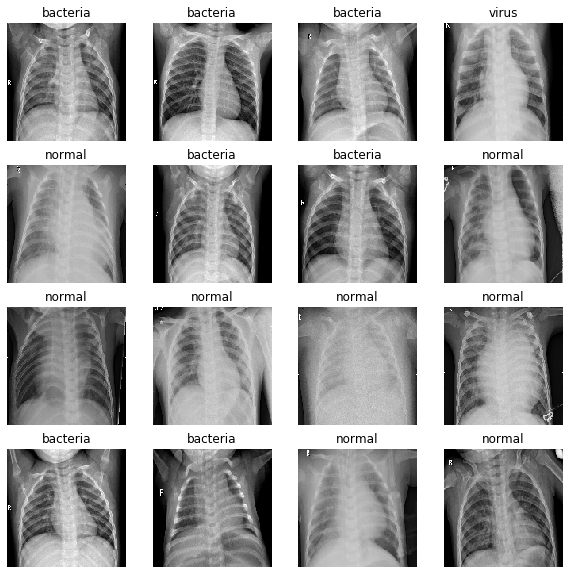

In [13]:
def show_batch(image_batch, label_batch, size):
  plt.figure(figsize=(10,10))
  rows_cols = ceil(sqrt(size))
  
  for n in range(size):
      ax = plt.subplot(rows_cols,rows_cols,n+1)
      plt.imshow(image_batch[n][:,:,0], cmap="gray")
      plt.title(LABELS[(label_batch[n]==1).tolist().index(True)])
      plt.axis('off')
      
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch, BATCH_SIZE)

## Model
### Simple CNN

In [14]:
POOL_SIZE = (2,2)
KERNEL_SIZE = (3,3)
ACTIVATION_HIDDEN_LAYERS = 'relu'
ACTIVATION_OUTPUT_LAYER = 'softmax'
LOSS = 'categorical_crossentropy'
OPTIMIZER = 'rmsprop' # TODO rmsprop or adam
METRICS = ['accuracy']
EPOCH = 50 # TODO increase

if tf.keras.backend.image_data_format() == 'channels_first':
    INPUT_SHAPE = (INPUT_SHAPE[-1], INPUT_SHAPE[0], INPUT_SHAPE[1])

model = Sequential()

model.add(Conv2D(32, KERNEL_SIZE, input_shape=INPUT_SHAPE))
model.add(Activation(ACTIVATION_HIDDEN_LAYERS))
model.add(MaxPooling2D(pool_size=POOL_SIZE))

model.add(Conv2D(32, KERNEL_SIZE))
model.add(Activation(ACTIVATION_HIDDEN_LAYERS))
model.add(MaxPooling2D(pool_size=POOL_SIZE))

model.add(Conv2D(64, KERNEL_SIZE))
model.add(Activation(ACTIVATION_HIDDEN_LAYERS))
model.add(MaxPooling2D(pool_size=POOL_SIZE))

model.add(Flatten()) # converts 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation(ACTIVATION_HIDDEN_LAYERS))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation(ACTIVATION_OUTPUT_LAYER))

if CONFIG["load"]:
    if CONFIG["load_remote"]:
        path = WEIGHT_PATH["remote"]
    else:
        path = WEIGHT_PATH["local"]
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    
    if CONFIG["load_model"]:    
        model = load_model(path+"model.h5")
    else:
        model.load_weights(path+"weights.h5")
else:
    model.save_weights(WEIGHT_PATH["local"]+'weights.h5')
    model.save(WEIGHT_PATH["local"]+'model.h5')
    
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    model.fit_generator(train_generator, validation_data=val_generator, epochs=EPOCH, steps_per_epoch=steps_per_epoch["train"], validation_steps=steps_per_epoch["val"])

#predict = model.predict_generator(test_generator, steps = steps_per_epoch["test"])
val_score = model.evaluate_generator(val_generator, steps_per_epoch["val"])
test_score = model.evaluate_generator(test_generator, steps_per_epoch["test"])

print(val_score)
print(test_score)

[1.8929777145385742, 0.7083333730697632]
[1.5025397539138794, 0.7996794581413269]


### Transfer learning (VGG16)

In [15]:
def save_bottlebeck_features():
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    
    train_generator = datagen.flow_from_directory(PATHS["train"], target_size = INPUT_SHAPE[0:2], 
                                                  batch_size=BATCH_SIZE, 
                                                  class_mode=None, shuffle="false")
    
    bottleneck_features_train = model.predict_generator(train_generator, steps_per_epoch["train"])
    np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train) # Change dir
    
    val_generator = datagen.flow_from_directory(PATHS["val"], target_size = INPUT_SHAPE[0:2], 
                                                  batch_size=BATCH_SIZE, 
                                                  class_mode=None, shuffle="false")
    
    bottleneck_features_val = model.predict_generator(val_generator, steps_per_epoch["val"])
    np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_val)

def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
    
    validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
    
    model = Sequential()
    model.add(Flatten(input_shape=INPUT_SHAPE))
    model.add(Dense(256, activation=ACTIVATION_HIDDEN_LAYERS))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation=ACTIVATION_OUTPUT_LAYER))
    
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    
    model.save_weights("top_weights.h5") # Change dir
    model.save("top_model.h5")
    
    #model.fit_generator(train_generator, validation_data=val_generator, epochs=EPOCH, steps_per_epoch=steps_per_epoch["train"], validation_steps=steps_per_epoch["val"])
    #model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(validation_data, validation_labels))
    
#save_bottlebeck_features()
#train_top_model()

In [19]:
#def gray_to_rgb(img):
#    return np.repeat(img, 3, 2)

INPUT_SHAPE3 = INPUT_SHAPE[0:2]+(3,)
if tf.keras.backend.image_data_format() == 'channels_first':
    INPUT_SHAPE3 = (INPUT_SHAPE3[-1], INPUT_SHAPE3[0], INPUT_SHAPE3[1])
    
COLOR_MODE = 'rgb'
WEIGHTS = "imagenet"

#datagen = ImageDataGenerator(rescale=RESCALE, preprocessing_function=gray_to_rgb)
train_generator = datagen.flow_from_directory(PATHS["train"], target_size = INPUT_SHAPE[0:2], batch_size=BATCH_SIZE, color_mode=COLOR_MODE, class_mode=CLASS_MODE)
val_generator = datagen.flow_from_directory(PATHS["val"], target_size = INPUT_SHAPE[0:2], batch_size=BATCH_SIZE, color_mode=COLOR_MODE, class_mode=CLASS_MODE)
test_generator = datagen.flow_from_directory(PATHS["test"], target_size = INPUT_SHAPE[0:2], batch_size=BATCH_SIZE, color_mode=COLOR_MODE, class_mode=CLASS_MODE)

vgg16 = applications.VGG16(input_shape=INPUT_SHAPE3, include_top=False, weights=WEIGHTS)

for layer in vgg16.layers:
    layer.trainable=False
    
vgg16.summary()

model = Sequential([
    vgg16,
    
    Flatten(),
    Dense(512,activation=ACTIVATION_HIDDEN_LAYERS),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(64,activation=ACTIVATION_HIDDEN_LAYERS),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(3, activation=ACTIVATION_OUTPUT_LAYER)
])

model.summary()

# Create a function
if CONFIG["load"]:
    if CONFIG["load_remote"]:
        path = WEIGHT_PATH["remote"]
    else:
        path = WEIGHT_PATH["local"]
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    
    if CONFIG["load_model"]:    
        model = load_model("../res/modelcp/remote/model_vgg16.h5") # Change
    else:
        model.load_weights("../res/modelcp/remote/weights_vgg16.h5") # Change
else:
    model.save_weights(WEIGHT_PATH["local"]+'weights_vgg16.h5')
    model.save(WEIGHT_PATH["local"]+'model_vgg16.h5')
    
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    history = model.fit_generator(train_generator, validation_data=val_generator, epochs=EPOCH, steps_per_epoch=steps_per_epoch["train"], validation_steps=steps_per_epoch["val"])

val_score = model.evaluate_generator(val_generator, steps_per_epoch["val"])
test_score = model.evaluate_generator(test_generator, steps_per_epoch["test"])

print(val_score)
print(test_score)

Found 5216 images belonging to 3 classes.
Found 16 images belonging to 3 classes.
Found 624 images belonging to 3 classes.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
____

#### Plot learning

In [ ]:
def plot_learning(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.figure()
    
    # Plot training and validation loss per epoch
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
if COLAB:
    plot_learning(history)